In [39]:
import os
import glob
from pathlib import Path
import yaml
import re

import logging

import pandas as pd 
import numpy as np 

import matplotlib.pyplot as plt 
import seaborn as sns 

from sklearn.model_selection import train_test_split, KFold

from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

import pyarrow.parquet as pq
import pyarrow as pa


import hashlib


# Custom Utilities Module
from utils.paths import get_paths
from utils.file_io import load_data, save_data


# Show more columns
pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 200)

# Initiate Logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [2]:
# Get Path's Object
paths = get_paths()

logger.info(f"Project Root Path Loaded: {paths.root}")    
    
logger.info(f"Project Data Path Loaded: {paths.data}")

logger.info(f"Data Bronze Path Loaded: {paths.data_bronze}")

logger.info(f"Data Bronze Training Path Loaded: {paths.data_bronze_train}")
logger.info(f"Data Bronze Testing Path Loaded: {paths.data_bronze_test}")

logger.info(f"Data Silver Path Loaded: {paths.data_silver}")

logger.info(f"Data Silver Training Path Loaded: {paths.data_silver_train}")
logger.info(f"Data Silver Testing Path Loaded: {paths.data_silver_test}")

INFO:__main__:Project Root Path Loaded: /workspace
INFO:__main__:Project Data Path Loaded: /workspace/data
INFO:__main__:Data Bronze Path Loaded: /workspace/data/bronze
INFO:__main__:Data Bronze Training Path Loaded: /workspace/data/bronze/train
INFO:__main__:Data Bronze Testing Path Loaded: /workspace/data/bronze/test
INFO:__main__:Data Silver Path Loaded: /workspace/data/silver
INFO:__main__:Data Silver Training Path Loaded: /workspace/data/silver/train
INFO:__main__:Data Silver Testing Path Loaded: /workspace/data/silver/test


In [3]:
# Debugging Cell
# Verifies Parquet file headers and footer and true size of the file

from pathlib import Path

p = Path("/workspace/data/bronze/tep_combined_bronze.parquet")
print("Exists:", p.exists(), "Size (GB):", round(p.stat().st_size / (1024**3), 2))

with open(p, "rb") as f:
    head = f.read(4)
    f.seek(-4, 2)
    tail = f.read(4)

print("Header:", head)
print("Footer:", tail)

Exists: True Size (GB): 1.42
Header: b'PAR1'
Footer: b'PAR1'


In [4]:
# Debugging Cell
# Captures the row groups, number of rows, and column names from the parquet file

import pyarrow.parquet as pq

pf = pq.ParquetFile("/workspace/data/bronze/tep_combined_bronze.parquet")
print("Row groups:", pf.num_row_groups)
print("Rows:", pf.metadata.num_rows)
print("Columns:", pf.schema_arrow.names[:20], "...")

Row groups: 15
Rows: 15330000
Columns: ['global_row_id', '_source_file', 'row_id', 'dataset_name', 'ingest_utc', 'run_id', 'split', 'is_labeled', 'label_type', 'faultNumber', 'simulationRun', 'sample', 'xmeas_1', 'xmeas_2', 'xmeas_3', 'xmeas_4', 'xmeas_5', 'xmeas_6', 'xmeas_7', 'xmeas_8'] ...


In [5]:
# Debugging Cell
# Loads only the meta columns from the parquet file and read/prints out the 



import pandas as pd

meta_cols = [
    "global_row_id", "_source_file", "row_id", "dataset_name", "ingest_utc",
    "run_id", "split", "is_labeled", "label_type"
]

df_meta = pd.read_parquet(
    "/workspace/data/bronze/tep_combined_bronze.parquet",
    columns=meta_cols,   # key: only a few columns
    engine="pyarrow"
)
df_meta.shape, df_meta.head()


((15330000, 9),
    global_row_id                _source_file  row_id dataset_name                        ingest_utc run_id  split is_labeled label_type
 0              0  TEP_FaultFree_Training.csv       0          TEP  2025-12-14T23:52:50.554169+00:00   <NA>  train        yes     normal
 1              1  TEP_FaultFree_Training.csv       1          TEP  2025-12-14T23:52:50.554169+00:00   <NA>  train        yes     normal
 2              2  TEP_FaultFree_Training.csv       2          TEP  2025-12-14T23:52:50.554169+00:00   <NA>  train        yes     normal
 3              3  TEP_FaultFree_Training.csv       3          TEP  2025-12-14T23:52:50.554169+00:00   <NA>  train        yes     normal
 4              4  TEP_FaultFree_Training.csv       4          TEP  2025-12-14T23:52:50.554169+00:00   <NA>  train        yes     normal)

In [6]:
pf = pq.ParquetFile(paths.data_bronze/"tep_combined_bronze.parquet")
print("Row groups:", pf.num_row_groups, "Rows:", pf.metadata.num_rows)

Row groups: 15 Rows: 15330000


In [7]:
# Load Data
# dataframe = load_data(paths.data_bronze, "tep_combined_bronze.parquet")

dataframe = load_data(paths.data_bronze_train, "tep_training_combined_bronze.parquet")

INFO:utils.file_io:Loading Parquet: /workspace/data/bronze/train/tep_training_combined_bronze.parquet


In [8]:
# Basic Dataframe Information/Summary

print("Shape:", dataframe.shape)
print("\nData types:")
print(dataframe.dtypes)

print("\nMemory usage (MB):")
print(dataframe.memory_usage(deep=True).sum() / (1024 ** 2))

print("\nFirst 15 rows:")
display(dataframe.head(15))

print("\nBasic numeric summary:")
display(dataframe.describe().T)

print("\nBasic object / categorical summary:")
display(dataframe.describe(include="object").T)

Shape: (5250000, 63)

Data types:
_source_file      object
dataset_name    category
run_id            object
split           category
is_labeled      category
                  ...   
xmv_7            float64
xmv_8            float64
xmv_9            float64
xmv_10           float64
xmv_11           float64
Length: 63, dtype: object

Memory usage (MB):
3550.053247451782

First 15 rows:


,_source_file,dataset_name,run_id,split,is_labeled,label_type,ingest_utc,_source_row_id,faultNumber,simulationRun,sample,xmeas_1,xmeas_2,xmeas_3,xmeas_4,xmeas_5,xmeas_6,xmeas_7,xmeas_8,xmeas_9,xmeas_10,xmeas_11,xmeas_12,xmeas_13,xmeas_14,xmeas_15,xmeas_16,xmeas_17,xmeas_18,xmeas_19,xmeas_20,xmeas_21,xmeas_22,xmeas_23,xmeas_24,xmeas_25,xmeas_26,xmeas_27,xmeas_28,xmeas_29,xmeas_30,xmeas_31,xmeas_32,xmeas_33,xmeas_34,xmeas_35,xmeas_36,xmeas_37,xmeas_38,xmeas_39,xmeas_40,xmeas_41,xmv_1,xmv_2,xmv_3,xmv_4,xmv_5,xmv_6,xmv_7,xmv_8,xmv_9,xmv_10,xmv_11
0,TEP_FaultFree_Training.csv,TEP,None,train,yes,normal,2025-12-16T21:44:57.030417+00:00,0,0,1,1,0.25038,3674.0,4529.0,9.2320,26.889,42.402,2704.3,74.863,120.41,0.33818,80.044,51.435,2632.9,25.029,50.528,3101.1,22.819,65.732,229.61,341.22,94.640,77.047,32.188,8.8933,26.383,6.8820,18.776,1.6567,32.958,13.823,23.978,1.2565,18.579,2.2633,4.8436,2.2986,0.017866,0.83570,0.098577,53.724,43.828,62.881,53.744,24.657,62.544,22.137,39.935,42.323,47.757,47.510,41.258,18.447
1,TEP_FaultFree_Training.csv,TEP,None,train,yes,normal,2025-12-16T21:44:57.030417+00:00,1,0,1,2,0.25109,3659.4,4556.6,9.4264,26.721,42.576,2705.0,75.000,120.41,0.33620,80.078,50.154,2633.8,24.419,48.772,3102.0,23.333,65.716,230.54,341.30,94.595,77.434,32.188,8.8933,26.383,6.8820,18.776,1.6567,32.958,13.823,23.978,1.2565,18.579,2.2633,4.8436,2.2986,0.017866,0.83570,0.098577,53.724,43.828,63.132,53.414,24.588,59.259,22.084,40.176,38.554,43.692,47.427,41.359,17.194
2,TEP_FaultFree_Training.csv,TEP,None,train,yes,normal,2025-12-16T21:44:57.030417+00:00,2,0,1,3,0.25038,3660.3,4477.8,9.4426,26.875,42.070,2706.2,74.771,120.42,0.33563,80.220,50.302,2635.5,25.244,50.071,3103.5,21.924,65.732,230.08,341.38,94.605,77.466,31.767,8.7694,26.095,6.8259,18.961,1.6292,32.985,13.742,23.897,1.3001,18.765,2.2602,4.8543,2.3900,0.017866,0.83570,0.098577,53.724,43.828,63.117,54.357,24.666,61.275,22.380,40.244,38.990,46.699,47.468,41.199,20.530
3,TEP_FaultFree_Training.csv,TEP,None,train,yes,normal,2025-12-16T21:44:57.030417+00:00,3,0,1,4,0.24977,3661.3,4512.1,9.4776,26.758,42.063,2707.2,75.224,120.39,0.33553,80.305,49.990,2635.6,23.268,50.435,3102.8,22.948,65.781,227.91,341.71,94.473,77.443,31.767,8.7694,26.095,6.8259,18.961,1.6292,32.985,13.742,23.897,1.3001,18.765,2.2602,4.8543,2.3900,0.017866,0.83570,0.098577,53.724,43.828,63.100,53.946,24.725,59.856,22.277,40.257,38.072,47.541,47.658,41.643,18.089
4,TEP_FaultFree_Training.csv,TEP,None,train,yes,normal,2025-12-16T21:44:57.030417+00:00,4,0,1,5,0.29405,3679.0,4497.0,9.3381,26.889,42.650,2705.1,75.388,120.39,0.32632,80.064,51.310,2632.4,26.099,50.480,3103.5,22.808,65.788,231.37,341.11,94.678,76.947,32.322,8.5821,26.769,6.8688,18.782,1.6396,33.071,13.834,24.228,1.0938,18.666,2.2193,4.8304,2.2416,0.017866,0.83570,0.098577,53.724,43.828,63.313,53.658,28.797,60.717,21.947,39.144,41.955,47.645,47.346,41.507,18.461
5,TEP_FaultFree_Training.csv,TEP,None,train,yes,normal,2025-12-16T21:44:57.030417+00:00,5,0,1,6,0.29303,3691.7,4502.2,9.3780,27.111,41.999,2703.8,75.050,120.39,0.33018,79.859,50.608,2632.2,27.856,50.448,3101.0,22.534,65.711,230.47,341.52,94.515,77.015,32.322,8.5821,26.769,6.8688,18.782,1.6396,33.071,13.834,24.228,1.0938,18.666,2.2193,4.8304,2.2416,0.041320,0.83341,0.113380,53.244,43.201,63.095,53.595,28.898,59.107,22.291,38.673,39.890,47.571,47.430,41.308,19.134
6,TEP_FaultFree_Training.csv,TEP,None,train,yes,normal,2025-12-16T21:44:57.030417+00:00,6,0,1,7,0.24301,3658.8,4541.6,9.3374,26.623,42.448,2704.0,75.498,120.39,0.33565,80.017,49.224,2632.8,25.113,49.559,3101.2,23.156,65.677,229.61,341.66,94.639,77.434,31.801,8.8537,26.288,6.8457,18.980,1.6407,32.708,13.771,23.350,1.2941,18.703,2.2659,4.8236,2.2975,0.041320,0.83341,0.113380,53.244,43.201,63.317,53.548,23.558,62.125,22.244,40.429,35.816,45.514,47.508,41.338,17.625
7,TEP_FaultFree_Training.csv,TEP,None,train,yes,normal,2025-12-16T21:44:57.030417+00:00,7,0,1,8,0.24090,3653.3,4500.0,9.3495,27.075,42.412,2704.9,74.883,120.42,0.33670,80.173,50.580,


Basic numeric summary:


,count,mean,std,min,25%,50%,75%,max
_source_row_id,5250000.0,2.386904e+06,1.496725e+06,0.000000,1.062500e+06,2.375000e+06,3.687499e+06,4.999999e+06
faultNumber,5250000.0,1.000000e+01,6.055301e+00,0.000000,5.000000e+00,1.000000e+01,1.500000e+01,2.000000e+01
simulationRun,5250000.0,2.505000e+02,1.443373e+02,1.000000,1.257500e+02,2.505000e+02,3.752500e+02,5.000000e+02
sample,5250000.0,2.505000e+02,1.443373e+02,1.000000,1.257500e+02,2.505000e+02,3.752500e+02,5.000000e+02
xmeas_1,5250000.0,2.608409e-01,1.461083e-01,-0.004735,2.191800e-01,2.510900e-01,2.823600e-01,1.017500e+00
xmeas_2,5250000.0,3.663777e+03,4.277760e+01,3327.400000,3.636800e+03,3.663300e+03,3.690100e+03,3.906700e+03
xmeas_3,5250000.0,4.506178e+03,1.086998e+02,3540.700000,4.470000e+03,4.508500e+03,4.547100e+03,5.175800e+03
xmeas_4,5250000.0,9.369238e+00,3.563536e-01,6.639900,9.266000e+00,9.354600e+00,9.452500e+00,1.224000e+01
xmeas_5,5250000.0,2.690159e+01,2.310677e-01,25.386000,2.676000e+01,2.690100e+01,2.704300e+01,2.848600e+01
xmeas_6,5250000.0,4.236293e+01,3.132701e-01,39.656000,4.218200e+01,4.234800e+01,4.252200e+01,4.465300e+01



Basic object / categorical summary:


,count,unique,top,freq
_source_file,5250000,2,TEP_Faulty_Training.csv,5000000
run_id,0,0,NaN,NaN
label_type,5250000,2,abnormal,5000000
ingest_utc,5250000,2,2025-12-16T21:46:37.376951+00:00,5000000


In [9]:
#

print("Shape:", dataframe.shape)
print("Full-row duplicates:", int(dataframe.duplicated().sum()))

nulls = dataframe.isna().sum().to_frame("null_count")
nulls["null_pct"] = (nulls["null_count"] / len(dataframe) * 100).round(2)
display(nulls.sort_values("null_pct", ascending=False).head(65))

Shape: (5250000, 63)
Full-row duplicates: 0


,null_count,null_pct
run_id,5250000,100.0
_source_file,0,0.0
dataset_name,0,0.0
split,0,0.0
is_labeled,0,0.0
...,...,...
xmv_7,0,0.0
xmv_8,0,0.0
xmv_9,0,0.0
xmv_10,0,0.0


In [10]:
# Add Silver Processing Column and timestamp start
dataframe["silver_processed_at"] = pd.Timestamp.utcnow().isoformat()


In [11]:
#

def to_snake(
        name, 
        *, 
        split_letters_digits = True
    ):

    s = str(name).strip()

    # Replace whitespace and hyphens with underscore early
    s = re.sub(r"[\s\-]+", "_", s)

    # Convert CamelCase / PascalCase boundaries to underscore:
    # "faultNumber" -> "fault_Number"
    s = re.sub(r"(.)([A-Z][a-z]+)", r"\1_\2", s)
    # "HPCSpeed" -> "HPC_Speed"
    s = re.sub(r"([a-z0-9])([A-Z])", r"\1_\2", s)

    # Optionally split letters<->digits: "sensor1" -> "sensor_1"
    # but "t24" could become "t_24" (some people prefer that, some don’t)
    if split_letters_digits:
        s = re.sub(r"([A-Za-z])(\d)", r"\1_\2", s)
        s = re.sub(r"(\d)([A-Za-z])", r"\1_\2", s)

    # Lowercase
    s = s.lower()

    # Remove any non-word chars except underscore
    s = re.sub(r"[^\w]+", "_", s)

    # Collapse multiple underscores and trim
    s = re.sub(r"_+", "_", s).strip("_")

    return s

# https://stackoverflow.com/questions/1175208/elegant-python-function-to-convert-camelcase-to-snake-case?utm_source=chatgpt.com


def standardize_columns_snake(
    dataframe,
    *,
    split_letters_digits = True,
    ensure_unique = True
):
    dataframe = dataframe.copy()
    
    new_columns = [to_snake(column, split_letters_digits=split_letters_digits) for column in dataframe.columns]

    if ensure_unique:
        # Make duplicates unique
        seen_columns = {}
        unique_columns = []
        for column in new_columns:
            if column not in seen_columns:
                seen_columns[column] = 1
                unique_columns.append(column)
            else:
                seen_columns[column] += 1
                unique_columns.append(f"{column}_{seen_columns[column]}")

        new_columns = unique_columns

    dataframe.columns = new_columns

    return dataframe



In [ ]:
#
dataframe = standardize_columns_snake(dataframe, split_letters_digits=True)

In [26]:
dataframe.columns

Index(['source_file', 'dataset_name', 'run_id', 'split', 'is_labeled', 'label_type', 'ingest_utc', 'source_row_id', 'fault_number', 'simulation_run', 'sample', 'xmeas_1', 'xmeas_2', 'xmeas_3',
       'xmeas_4', 'xmeas_5', 'xmeas_6', 'xmeas_7', 'xmeas_8', 'xmeas_9', 'xmeas_10', 'xmeas_11', 'xmeas_12', 'xmeas_13', 'xmeas_14', 'xmeas_15', 'xmeas_16', 'xmeas_17', 'xmeas_18', 'xmeas_19',
       'xmeas_20', 'xmeas_21', 'xmeas_22', 'xmeas_23', 'xmeas_24', 'xmeas_25', 'xmeas_26', 'xmeas_27', 'xmeas_28', 'xmeas_29', 'xmeas_30', 'xmeas_31', 'xmeas_32', 'xmeas_33', 'xmeas_34', 'xmeas_35',
       'xmeas_36', 'xmeas_37', 'xmeas_38', 'xmeas_39', 'xmeas_40', 'xmeas_41', 'xmv_1', 'xmv_2', 'xmv_3', 'xmv_4', 'xmv_5', 'xmv_6', 'xmv_7', 'xmv_8', 'xmv_9', 'xmv_10', 'xmv_11',
       'silver_processed_at', 'anomaly_flag', 'label_source', 'asset_id', 'event_step', 'time_source', 'event_time'],
      dtype='object')

In [13]:
'''

def standardize_columns(dataframe):
    dataframe = dataframe.copy()
    dataframe.columns = (
        pd.Index(dataframe.columns)
          .astype(str)
          .str.strip()
          .str.lower()
          .str.replace(r"\s+", "_", regex=True)
          .str.replace("-", "_")
    )
    return dataframe

dataframe = standardize_columns(dataframe)

''' 

'\n\ndef standardize_columns(dataframe):\n    dataframe = dataframe.copy()\n    dataframe.columns = (\n        pd.Index(dataframe.columns)\n          .astype(str)\n          .str.strip()\n          .str.lower()\n          .str.replace(r"\\s+", "_", regex=True)\n          .str.replace("-", "_")\n    )\n    return dataframe\n\ndataframe = standardize_columns(dataframe)\n\n'

In [14]:
# Get unique values for faultNumber
dataframe['fault_number'].unique()


array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20])

In [15]:
#
dataframe_faulttypes = dataframe.loc[dataframe["label_type"].eq("abnormal"), ["fault_number"]]

#
has_nonzero = dataframe_faulttypes["fault_number"].ne(0).any()
has_nonzero

np.True_

In [16]:

#
nonzero_faults = (
    dataframe.loc[dataframe["label_type"].eq("abnormal") & dataframe["fault_number"].ne(0), "fault_number"]
      .value_counts()
      .sort_index()
)

nonzero_faults

fault_number
1     250000
2     250000
3     250000
4     250000
5     250000
6     250000
7     250000
8     250000
9     250000
10    250000
11    250000
12    250000
13    250000
14    250000
15    250000
16    250000
17    250000
18    250000
19    250000
20    250000
Name: count, dtype: int64

In [17]:
#
print(dataframe["fault_number"].dtype)

int64


In [18]:
# Lets lower the int type and fill any nulls just in case. 
fault_number = pd.to_numeric(dataframe["fault_number"], errors="coerce").fillna(0)

# Create anomaly flag column
dataframe["anomaly_flag"] = (fault_number != 0).astype("int8")

# Create a label to indicate source
dataframe["label_source"] = f"tep:{fault_number}!=0"



In [19]:
# TEP Dataset does not have a clearly labeled machine/module/unit for each sensor.
# We can infer what subsystem the sensor belongs to but for now we will handle the 
# inference of subsystem during dashboarding/results and label all as TEP process

dataframe["asset_id"] = "tep_process"

In [20]:
# 
dataframe["run_id"] = "run_0"

In [21]:
#
dataframe["event_step"] = pd.to_numeric(dataframe["sample"], errors="coerce").astype("Int64")

# 
dataframe["time_source"] = f"step:sample"



In [22]:
# 
dataframe["event_time"] = pd.NaT


In [27]:
# 
group_columns = ["dataset_name", "split", "run_id", "asset_id"]
sort_columns = group_columns + ["event_step", "source_row_id"]

# 
dataframe = dataframe.sort_values(sort_columns, kind="mergesort").copy()

# 
dataframe["time_index"] = dataframe.groupby(group_columns).cumcount()

/tmp/ipykernel_374704/3182526394.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dataframe["time_index"] = dataframe.groupby(group_columns).cumcount()


In [28]:
# ---------- Deterministic event_id ----------
# stable key string then hash (short, deterministic)

key = (
    dataframe["dataset_name"].astype(str) + "|" +
    dataframe["split"].astype(str) + "|" +
    dataframe["run_id"].astype(str) + "|" +
    dataframe["asset_id"].astype(str) + "|" +
    dataframe["event_step"].astype(str)
)


dataframe["event_id"] = key.map(lambda s: hashlib.md5(s.encode("utf-8")).hexdigest())

In [29]:
# Conversion Meta Columns

dataframe["unit_map_version"] = "unified_v1"
dataframe["conversion_applied"] = False
dataframe["conversion_log"] = ""


In [30]:
# Unified Metics
# 1. Temperature - Celsius 
# 2. Pressure - kPa
# 3. Flow - L/min
# 4. Vibration - g
# 5. Current - A
# 6. Voltage - V
# 7. Speed / RPM - RPM
# 8. Torque - N·m 
# 9. Displacement - mm  
# 10. Acoustic - dB
# 11. Chemical Concentration - ppm
# 12. Misc Process Variables (Levels, Valves, Setpoints, Flags, Modes) - N/A 



G_STD = 9.80665
PSI_TO_KPA = 6.894757293168
M3H_TO_LMIN = 1000.0 / 60.0
RANKINE_TO_CELSIUS = 491.67
LBFT_TO_NM = 1.35582
HZ_TO_RPM = 60


def _to_numeric(s: pd.Series):
    return pd.to_numeric(s, errors="coerce")


CONVERSIONS = {
    "identity": lambda x: _to_numeric(x),

    # Temp
    "k_to_c": lambda x: _to_numeric(x) - 273.15,
    "f_to_c": lambda x: ((_to_numeric(x) - 32) * (5/9)),
    "ra_to_c": lambda x: ((_to_numeric(x) - 491.67)*(5/9)),
    "re_to_c": lambda x: _to_numeric(x) * (5/4),

    # Pressure
    "psi_to_kpa": lambda x: _to_numeric(x) * PSI_TO_KPA,
    "bar_to_kpa": lambda x: _to_numeric(x) * 100,

    # Flow
    "m3h_to_lmin": lambda x: _to_numeric(x) * M3H_TO_LMIN,

    # Torgue
    "lbft_to_nm": lambda x: _to_numeric(x) * LBFT_TO_NM,

    # Vibration
    "ms2_to_g": lambda x: _to_numeric(x) / G_STD,

    # Speed
    "hz_to_rpm": lambda x: _to_numeric(x) * HZ_TO_RPM,

    # Checmical Concentration
    "fraction_to_ppm": lambda x: _to_numeric(x) * 1_000_000.0,
    "molpct_to_fraction": lambda x: _to_numeric(x) / 100,

    # Current
    "ma_to_a": lambda x: _to_numeric(x) / 1000,

    # Voltage
    "mv_to_v": lambda x: _to_numeric(x) / 1000,
    
    # Misc
    "pct_to_fraction": lambda x: _to_numeric(x) / 100.0,

    #
}

def apply_column_conversion(
    dataframe,
    column,
    conversion_key,
    *,
    raw_suffix = "_raw",
    applied_column = "conversion_applied",
    log_column = "conversion_log",
    delimiter = "; ",
    clean_nonfinite = True,
    avoid_duplicate_log_tokens = True,
):
    
    if column not in dataframe.columns:
        raise KeyError(f"Column '{column}' not found.")
    
    if conversion_key not in CONVERSIONS:
        raise KeyError(f"Unknown conversion_key '{conversion_key}'.")

    # Preserve raw once
    raw_column = f"{column}{raw_suffix}"
    if raw_column not in dataframe.columns:
        dataframe[raw_column] = dataframe[column]

    # Convert in place
    dataframe[column] = CONVERSIONS[conversion_key](dataframe[column])
    if clean_nonfinite:
        dataframe[column] = dataframe[column].replace([np.inf, -np.inf], np.nan)

    # Update metadata
    dataframe[applied_column] = True
    token = f"{column}:{conversion_key}"
    current = dataframe[log_column].iloc[0] if len(dataframe) else ""

    if current:
        if avoid_duplicate_log_tokens:
            tokens = current.split(delimiter)
            if token not in tokens:
                dataframe[log_column] = current + delimiter + token
        else:
            dataframe[log_column] = current + delimiter + token
    else:
        dataframe[log_column] = token

    return dataframe


In [34]:


# Temp
# xmeas_9, XMEAS_11, XMEAS_18, XMEAS_21, XMEAS_22
# Already in Celsius


# Pressure
# XMEAS_7, XMEAS_13, XMEAS_16, 
# Already in kPA

# Flow
# m3/hr - XMEAS_14, XMEAS_17
# kg/hr - XMEAS_2, XMEAS_3, XMEAS_19  
# kscmh - XMEAS_1, XMEAS_4, XMEAS_5, XMEAS_6, XMEAS_10
# Conversions from m3/hr to L/min is save, but kscmh and kg/hr is not, these should stay as-is.

flow_conversions = ["xmeas_14", "xmeas_17"]

# Level
# XMEAS_8, XMEAS_12, XMEAS_15, 

level_conversions = ["xmeas_8", "xmeas_12", "xmeas_15"]

# Chemical
# XMEAS_23, XMEAS_24, XMEAS_25, XMEAS_26, XMEAS_27, XMEAS_28, XMEAS_29, XMEAS_30, XMEAS_31, 
# XMEAS_32, XMEAS_33, XMEAS_34, XMEAS_35, XMEAS_36, XMEAS_37, XMEAS_38, XMEAS_39, XMEAS_40,
# XMEAS_41

chemical_conversions = ["xmeas_23", "xmeas_24", "xmeas_25", "xmeas_26", "xmeas_27", "xmeas_28", "xmeas_29", "xmeas_30", "xmeas_31", "xmeas_32", "xmeas_33", "xmeas_34", "xmeas_35", "xmeas_36", "xmeas_37", "xmeas_38", "xmeas_39", "xmeas_40", "xmeas_41"]



for column in chemical_conversions:
    if column in dataframe.columns:
        dataframe = apply_column_conversion(dataframe, column, "molpct_to_fraction")


for column in level_conversions:
    if column in dataframe.columns:
        dataframe = apply_column_conversion(dataframe, column, "pct_to_fraction")



for column in flow_conversions:
    if column in dataframe.columns:
        dataframe = apply_column_conversion(dataframe, column, "m3h_to_lmin")

In [35]:
dataframe.columns

Index(['source_file', 'dataset_name', 'run_id', 'split', 'is_labeled', 'label_type', 'ingest_utc', 'source_row_id', 'fault_number', 'simulation_run', 'sample', 'xmeas_1', 'xmeas_2', 'xmeas_3',
       'xmeas_4', 'xmeas_5', 'xmeas_6', 'xmeas_7', 'xmeas_8', 'xmeas_9', 'xmeas_10', 'xmeas_11', 'xmeas_12', 'xmeas_13', 'xmeas_14', 'xmeas_15', 'xmeas_16', 'xmeas_17', 'xmeas_18', 'xmeas_19',
       'xmeas_20', 'xmeas_21', 'xmeas_22', 'xmeas_23', 'xmeas_24', 'xmeas_25', 'xmeas_26', 'xmeas_27', 'xmeas_28', 'xmeas_29', 'xmeas_30', 'xmeas_31', 'xmeas_32', 'xmeas_33', 'xmeas_34', 'xmeas_35',
       'xmeas_36', 'xmeas_37', 'xmeas_38', 'xmeas_39', 'xmeas_40', 'xmeas_41', 'xmv_1', 'xmv_2', 'xmv_3', 'xmv_4', 'xmv_5', 'xmv_6', 'xmv_7', 'xmv_8', 'xmv_9', 'xmv_10', 'xmv_11',
       'silver_processed_at', 'anomaly_flag', 'label_source', 'asset_id', 'event_step', 'time_source', 'event_time', 'time_index', 'event_id', 'unit_map_version', 'conversion_applied',
       'conversion_log', 'xmeas_23_raw', 'xmeas_24

In [38]:
dataframe.head()

,source_file,dataset_name,run_id,split,is_labeled,label_type,ingest_utc,source_row_id,fault_number,simulation_run,sample,xmeas_1,xmeas_2,xmeas_3,xmeas_4,xmeas_5,xmeas_6,xmeas_7,xmeas_8,xmeas_9,xmeas_10,xmeas_11,xmeas_12,xmeas_13,xmeas_14,xmeas_15,xmeas_16,xmeas_17,xmeas_18,xmeas_19,xmeas_20,xmeas_21,xmeas_22,xmeas_23,xmeas_24,xmeas_25,xmeas_26,xmeas_27,xmeas_28,xmeas_29,xmeas_30,xmeas_31,xmeas_32,xmeas_33,xmeas_34,xmeas_35,xmeas_36,xmeas_37,xmeas_38,xmeas_39,xmeas_40,xmeas_41,xmv_1,xmv_2,xmv_3,xmv_4,xmv_5,xmv_6,xmv_7,xmv_8,xmv_9,xmv_10,xmv_11,silver_processed_at,anomaly_flag,label_source,asset_id,event_step,time_source,event_time,time_index,event_id,unit_map_version,conversion_applied,conversion_log,xmeas_23_raw,xmeas_24_raw,xmeas_25_raw,xmeas_26_raw,xmeas_27_raw,xmeas_28_raw,xmeas_29_raw,xmeas_30_raw,xmeas_31_raw,xmeas_32_raw,xmeas_33_raw,xmeas_34_raw,xmeas_35_raw,xmeas_36_raw,xmeas_37_raw,xmeas_38_raw,xmeas_39_raw,xmeas_40_raw,xmeas_41_raw,xmeas_8_raw,xmeas_12_raw,xmeas_15_raw,xmeas_14_raw,xmeas_17_raw
0,TEP_FaultFree_Training.csv,TEP,run_0,train,yes,normal,2025-12-16T21:44:57.030417+00:00,0,0,1,1,0.25038,3674.0,4529.0,9.2320,26.889,42.402,2704.3,0.74863,120.41,0.33818,80.044,0.51435,2632.9,417.150000,0.50528,3101.1,380.316667,65.732,229.61,341.22,94.640,77.047,0.32188,0.088933,0.26383,0.06882,0.18776,0.016567,0.32958,0.13823,0.23978,0.012565,0.18579,0.022633,0.048436,0.022986,0.000179,0.008357,0.000986,0.53724,0.43828,62.881,53.744,24.657,62.544,22.137,39.935,42.323,47.757,47.510,41.258,18.447,2025-12-17T19:40:11.767924+00:00,0,tep:0 0\n1 0\n2 ...,tep_process,1,step:sample,NaT,0,a82ca26a6ea07f4f9d75093873d81e38,unified_v1,True,xmeas_23:molpct_to_fraction; xmeas_24:molpct_t...,32.188,8.8933,26.383,6.882,18.776,1.6567,32.958,13.823,23.978,1.2565,18.579,2.2633,4.8436,2.2986,0.017866,0.8357,0.098577,53.724,43.828,74.863,51.435,50.528,25.029,22.819
250000,TEP_Faulty_Training.csv,TEP,run_0,train,yes,abnormal,2025-12-16T21:46:37.376951+00:00,0,1,1,1,0.25038,3674.0,4529.0,9.2320,26.889,42.402,2704.3,0.74863,120.41,0.33818,80.044,0.51435,2632.9,417.150000,0.50528,3101.1,380.316667,65.732,229.61,341.22,94.640,77.047,0.32188,0.088933,0.26383,0.06882,0.18776,0.016567,0.32958,0.13823,0.23978,0.012565,0.18579,0.022633,0.048436,0.022986,0.000179,0.008357,0.000986,0.53724,0.43828,62.881,53.744,24.657,62.544,22.137,39.935,42.323,47.757,47.510,41.258,18.447,2025-12-17T19:40:11.767924+00:00,1,tep:0 0\n1 0\n2 ...,tep_process,1,step:sample,NaT,1,a82ca26a6ea07f4f9d75093873d81e38,unified_v1,True,xmeas_23:molpct_to_fraction; xmeas_24:molpct_t...,32.188,8.8933,26.383,6.882,18.776,1.6567,32.958,13.823,23.978,1.2565,18.579,2.2633,4.8436,2.2986,0.017866,0.8357,0.098577,53.724,43.828,74.863,51.435,50.528,25.029,22.819
500,TEP_FaultFree_Training.csv,TEP,run_0,train,yes,normal,2025-12-16T21:44:57.030417+00:00,500,0,2,1,0.25225,3683.6,4499.5,9.3306,26.713,42.420,2706.4,0.76095,120.43,0.34043,80.198,0.51619,2635.1,411.583333,0.50174,3102.5,399.366667,65.726,231.04,341.37,94.544,77.537,0.32188,0.088933,0.26383,0.06882,0.18776,0.016567,0.32958,0.13823,0.23978,0.012565,0.18579,0.022633,0.048436,0.022986,0.000179,0.008357,0.000986,0.53724,0.43828,62.716,54.098,24.474,62.513,22.178,39.661,42.864,46.936,47.381,41.427,15.683,2025-12-17T19:40:11.767924+00:00,0,tep:0 0\n1 0\n2 ...,tep_process,1,step:sample,NaT,2,a82ca26a6ea07f4f9d75093873d81e38,unified_v1,True,xmeas_23:molpct_to_fraction; xmeas_24:molpct_t...,32.188,8.8933,26.383,6.882,18.776,1.6567,32.958,13.823,23.978,1.2565,18.579,2.2633,4.8436,2.2986,0.017866,0.8357,0.098577,53.724,43.828,76.095,51.619,50.174,24.695,23.962
250500,TEP_Faulty_Training.csv,TEP,run_0,train,yes,abnormal,2025-12-16T21:46:37.376951+00:00,500,2,1,1,0.25038,3674.0,4529.0,9.2320,26.889,42.402,2704.3,0.74863,120.41,0.33818,80.044,0.51435,2632.9,417.150000,0.50528,3101.1,380.316667,65.732,229.61,341.22,94.640,77.047,0.32188,0.088933,0.26383,0.06882,0.18776,0.016567,0.32958,0.13823,0.23978,0.012565,0.18579,0.022633,0.048436,0.022986,0.00017

In [ ]:
# Save Data as Parquet
save_data(dataframe, paths.data_silver_train, "tep_training_combined_silver")

INFO:utils.file_io:Saving DataFrame to Parquet: /workspace/data/silver/train/tep_training_combined_first_half_silver.parquet
INFO:utils.file_io:Saved: tep_training_combined_first_half_silver.parquet | shape=(5251, 99) | columns=['source_file', 'dataset_name', 'run_id', 'split', 'is_labeled', 'label_type', 'ingest_utc', 'source_row_id', 'fault_number', 'simulation_run', 'sample', 'xmeas_1', 'xmeas_2', 'xmeas_3', 'xmeas_4', 'xmeas_5', 'xmeas_6', 'xmeas_7', 'xmeas_8', 'xmeas_9', 'xmeas_10', 'xmeas_11', 'xmeas_12', 'xmeas_13', 'xmeas_14', 'xmeas_15', 'xmeas_16', 'xmeas_17', 'xmeas_18', 'xmeas_19', 'xmeas_20', 'xmeas_21', 'xmeas_22', 'xmeas_23', 'xmeas_24', 'xmeas_25', 'xmeas_26', 'xmeas_27', 'xmeas_28', 'xmeas_29', 'xmeas_30', 'xmeas_31', 'xmeas_32', 'xmeas_33', 'xmeas_34', 'xmeas_35', 'xmeas_36', 'xmeas_37', 'xmeas_38', 'xmeas_39', 'xmeas_40', 'xmeas_41', 'xmv_1', 'xmv_2', 'xmv_3', 'xmv_4', 'xmv_5', 'xmv_6', 'xmv_7', 'xmv_8', 'xmv_9', 'xmv_10', 'xmv_11', 'silver_processed_at', 'anomaly_fl

PosixPath('/workspace/data/silver/train/tep_training_combined_first_half_silver.parquet')

In [60]:
dataframe_half = dataframe.sample(frac=0.5, random_state=42)
dataframe_quarter = dataframe.sample(frac=0.25, random_state=42)

In [61]:

# Save Data as Parquet
save_data(dataframe_quarter, paths.data_silver_train, "tep_training_combined_rand_samp_quarter_silver")

INFO:utils.file_io:Saving DataFrame to Parquet: /workspace/data/silver/train/tep_training_combined_rand_samp_quarter_silver.parquet
INFO:utils.file_io:Saved: tep_training_combined_rand_samp_quarter_silver.parquet | shape=(1312500, 99) | columns=['source_file', 'dataset_name', 'run_id', 'split', 'is_labeled', 'label_type', 'ingest_utc', 'source_row_id', 'fault_number', 'simulation_run', 'sample', 'xmeas_1', 'xmeas_2', 'xmeas_3', 'xmeas_4', 'xmeas_5', 'xmeas_6', 'xmeas_7', 'xmeas_8', 'xmeas_9', 'xmeas_10', 'xmeas_11', 'xmeas_12', 'xmeas_13', 'xmeas_14', 'xmeas_15', 'xmeas_16', 'xmeas_17', 'xmeas_18', 'xmeas_19', 'xmeas_20', 'xmeas_21', 'xmeas_22', 'xmeas_23', 'xmeas_24', 'xmeas_25', 'xmeas_26', 'xmeas_27', 'xmeas_28', 'xmeas_29', 'xmeas_30', 'xmeas_31', 'xmeas_32', 'xmeas_33', 'xmeas_34', 'xmeas_35', 'xmeas_36', 'xmeas_37', 'xmeas_38', 'xmeas_39', 'xmeas_40', 'xmeas_41', 'xmv_1', 'xmv_2', 'xmv_3', 'xmv_4', 'xmv_5', 'xmv_6', 'xmv_7', 'xmv_8', 'xmv_9', 'xmv_10', 'xmv_11', 'silver_processed

PosixPath('/workspace/data/silver/train/tep_training_combined_rand_samp_quarter_silver.parquet')

In [82]:
def infer_feature_cols_tep_safe(
    dataframe,
    label_columns=("fault_number", "anomaly_flag"),
    group_columns=("simulation_run", "run_id"),
    meta_columns=("source_row_id", "sample", "event_step", "time_index", "event_time"),
    prefer_prefixes=("xmeas_", "xmv_"),
    raw_mode="exclude",
):
    
    def is_raw(column: str) -> bool:
        return column.endswith("_raw")
    
    def sort_key(column: str):
        # Handles xmeas_1 or xmeas_1_raw
        base = column[:-4] if column.endswith("_raw") else column
        prefix, num = base.split("_", 1)
        return (prefix, int(num), 1 if column.endswith("_raw") else 0)
    
    # If the preferred prefixes exist, use them (TEP-accurate)
    pref = [column for column in dataframe.columns if column.startswith(prefer_prefixes)]

    if pref:
        if raw_mode == "exclude":
            pref = [column for column in pref if not is_raw(column)]
        elif raw_mode == "only":
            pref = [column for column in pref if is_raw(column)]
        elif raw_mode == "include":
            pass
        else:
            raise ValueError("raw_mode must be one of: 'exclude', 'only', 'include'")

        return sorted(pref, key=sort_key)


    #if pref:
        #return sorted(pref, key=lambda x: (x.split("_")[0], int(x.split("_")[1])))

    # Otherwise fall back to numeric minus exclusions
    exclude = set([column for column in label_columns if column in dataframe.columns] +
                  [column for column in group_columns if column in dataframe.columns] +
                  [column for column in meta_columns if column in dataframe.columns])

    numeric = dataframe.select_dtypes(include=[np.number]).columns

    cols = [column for column in numeric if column not in exclude]

    # Drop obvious ID-like numeric columns if any slip through
    id_like = re.compile(r"(?:^id$|_id$|^source_|row_id|index$|^sample$|step$|flag$)", re.IGNORECASE)
    columns = [column for column in columns if not id_like.search(column)]

    if raw_mode == "exclude":
        columns = [column for column in columns if not is_raw(column)]
    elif raw_mode == "only":
        cols = [column for column in columns if is_raw(column)]

    return columns

#feature_columns = infer_feature_cols_tep_safe(dataframe)


In [83]:

feature_columns = infer_feature_cols_tep_safe(dataframe, raw_mode="exclude")
len(feature_columns)


52

In [86]:
print(len(feature_columns))
print(feature_columns[:5], feature_columns[-5:])

52
['xmeas_1', 'xmeas_2', 'xmeas_3', 'xmeas_4', 'xmeas_5'] ['xmv_7', 'xmv_8', 'xmv_9', 'xmv_10', 'xmv_11']


In [87]:
assert not any(column.endswith("_raw") for column in feature_columns)

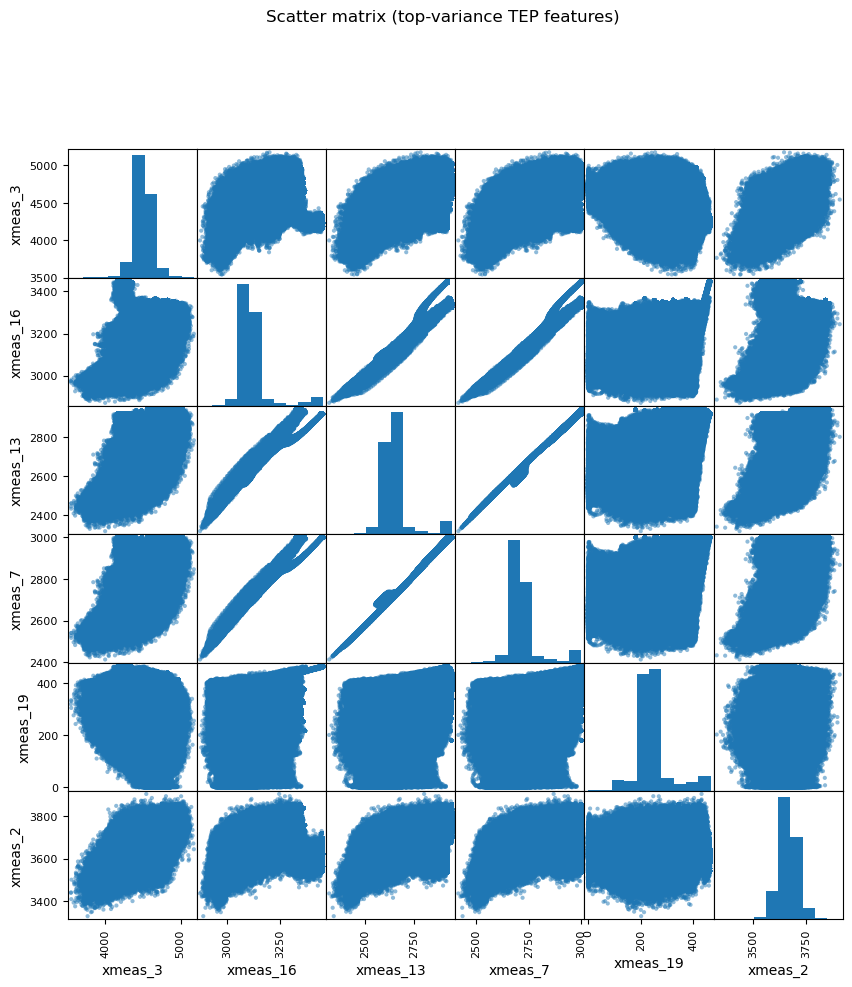

In [88]:
import numpy as np
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt

feature_cols_sorted_by_variance = (
    dataframe[feature_columns]
      .replace([np.inf, -np.inf], np.nan)
      .fillna(0.0)
      .var()
      .sort_values(ascending=False)
      .index.tolist()
)

top6 = feature_cols_sorted_by_variance[:6]
scatter_matrix(dataframe[top6].dropna(), figsize=(10,10), diagonal="hist")
plt.suptitle("Scatter matrix (top-variance TEP features)", y=1.02)
plt.show()

In [ ]:

FEATURE_PREFIXES = ("xmeas_", "xmv_")

feature_columns = [column for column in dataframe.columns if column.startswith(FEATURE_PREFIXES)]
feature_columns = sorted(feature_columns, key=lambda x: (x.split("_")[0], int(x.split("_")[1])))

len(feature_columns), feature_columns[:5], feature_columns[-5:]

In [64]:
import numpy as np

feature_cols_sorted_by_variance = (
    dataframe[feature_columns]
      .replace([np.inf, -np.inf], np.nan)
      .fillna(0.0)
      .var(numeric_only=True)
      .sort_values(ascending=False)
      .index
      .tolist()
)

# Example usage: take top 6 for a pair plot / scatter matrix
top_columns = feature_cols_sorted_by_variance[:6]
top_columns

['source_row_id', 'sample', 'event_step', 'xmeas_3', 'xmeas_16', 'xmeas_13']

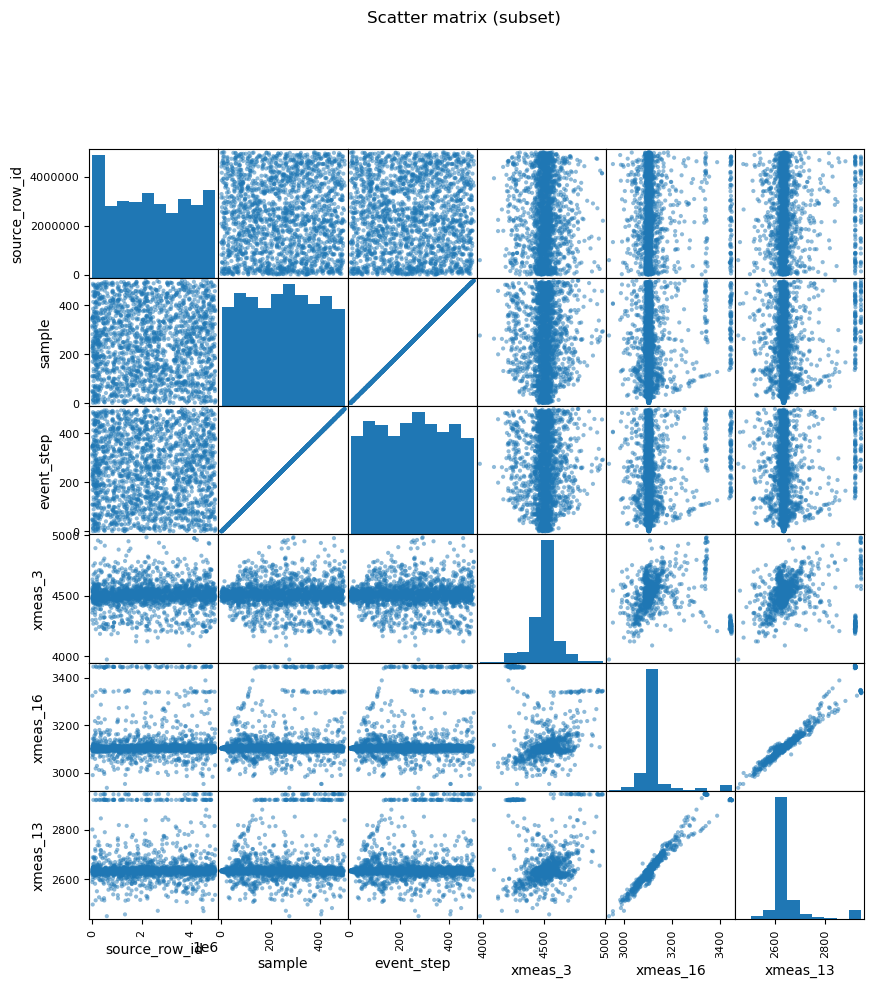

In [68]:
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt

def pairplot_subset(dataframe, columns, label_column=None, sample_n=2000, seed=42):
    dataframe = dataframe[columns + ([label_column] if label_column else [])].dropna()
    if len(dataframe) > sample_n:
        dataframe = dataframe.sample(sample_n, random_state=seed)

    ax = scatter_matrix(dataframe[columns], figsize=(10, 10), diagonal="hist")
    plt.suptitle("Scatter matrix (subset)", y=1.02)
    plt.show()

# Example:
top_columns = feature_cols_sorted_by_variance[:6]
pairplot_subset(dataframe, top_columns, label_column=LABEL_COLUMN)

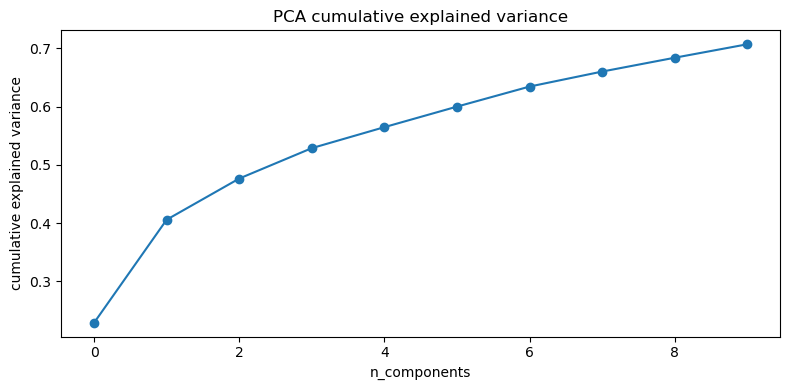

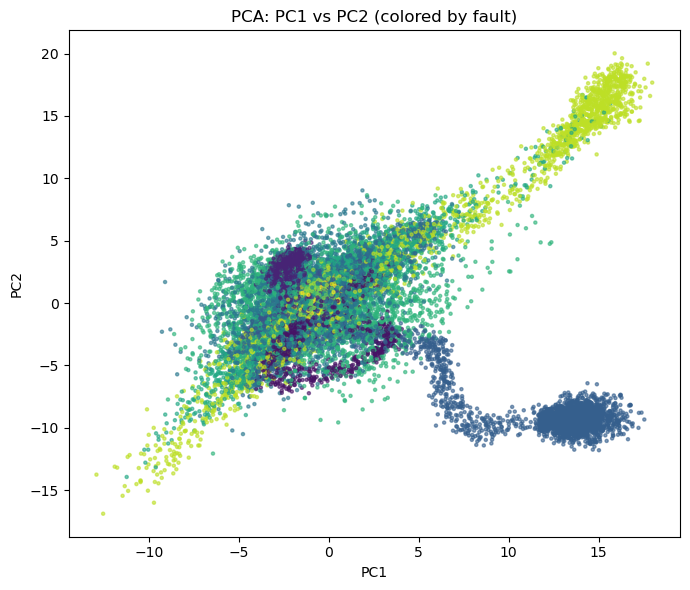

In [70]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

def pca_report(dataframe, feature_columns, label_column, sample_n=60000, seed=42, n_components=10):
    dataframe = dataframe[feature_columns + [label_column]].replace([np.inf, -np.inf], np.nan).fillna(0.0)
    if len(dataframe) > sample_n:
        dataframe = dataframe.sample(sample_n, random_state=seed)

    X = dataframe[feature_columns].values
    y = dataframe[label_column].astype(int).values

    Xz = StandardScaler().fit_transform(X)
    pca = PCA(n_components=n_components, random_state=seed)
    Xp = pca.fit_transform(Xz)

    plt.figure(figsize=(8,4))
    plt.plot(np.cumsum(pca.explained_variance_ratio_), marker="o")
    plt.title("PCA cumulative explained variance")
    plt.xlabel("n_components")
    plt.ylabel("cumulative explained variance")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(7,6))
    plt.scatter(Xp[:,0], Xp[:,1], s=5, alpha=0.6, c=y)
    plt.title("PCA: PC1 vs PC2 (colored by fault)")
    plt.xlabel("PC1"); plt.ylabel("PC2")
    plt.tight_layout()
    plt.show()

pca_report(dataframe, feature_columns, LABEL_COLUMN)

In [72]:
dataframe.head()

,source_file,dataset_name,run_id,split,is_labeled,label_type,ingest_utc,source_row_id,fault_number,simulation_run,sample,xmeas_1,xmeas_2,xmeas_3,xmeas_4,xmeas_5,xmeas_6,xmeas_7,xmeas_8,xmeas_9,xmeas_10,xmeas_11,xmeas_12,xmeas_13,xmeas_14,xmeas_15,xmeas_16,xmeas_17,xmeas_18,xmeas_19,xmeas_20,xmeas_21,xmeas_22,xmeas_23,xmeas_24,xmeas_25,xmeas_26,xmeas_27,xmeas_28,xmeas_29,xmeas_30,xmeas_31,xmeas_32,xmeas_33,xmeas_34,xmeas_35,xmeas_36,xmeas_37,xmeas_38,xmeas_39,xmeas_40,xmeas_41,xmv_1,xmv_2,xmv_3,xmv_4,xmv_5,xmv_6,xmv_7,xmv_8,xmv_9,xmv_10,xmv_11,silver_processed_at,anomaly_flag,label_source,asset_id,event_step,time_source,event_time,time_index,event_id,unit_map_version,conversion_applied,conversion_log,xmeas_23_raw,xmeas_24_raw,xmeas_25_raw,xmeas_26_raw,xmeas_27_raw,xmeas_28_raw,xmeas_29_raw,xmeas_30_raw,xmeas_31_raw,xmeas_32_raw,xmeas_33_raw,xmeas_34_raw,xmeas_35_raw,xmeas_36_raw,xmeas_37_raw,xmeas_38_raw,xmeas_39_raw,xmeas_40_raw,xmeas_41_raw,xmeas_8_raw,xmeas_12_raw,xmeas_15_raw,xmeas_14_raw,xmeas_17_raw
0,TEP_FaultFree_Training.csv,TEP,run_0,train,yes,normal,2025-12-16T21:44:57.030417+00:00,0,0,1,1,0.25038,3674.0,4529.0,9.2320,26.889,42.402,2704.3,0.74863,120.41,0.33818,80.044,0.51435,2632.9,417.150000,0.50528,3101.1,380.316667,65.732,229.61,341.22,94.640,77.047,0.32188,0.088933,0.26383,0.06882,0.18776,0.016567,0.32958,0.13823,0.23978,0.012565,0.18579,0.022633,0.048436,0.022986,0.000179,0.008357,0.000986,0.53724,0.43828,62.881,53.744,24.657,62.544,22.137,39.935,42.323,47.757,47.510,41.258,18.447,2025-12-17T19:40:11.767924+00:00,0,tep:0 0\n1 0\n2 ...,tep_process,1,step:sample,NaT,0,a82ca26a6ea07f4f9d75093873d81e38,unified_v1,True,xmeas_23:molpct_to_fraction; xmeas_24:molpct_t...,32.188,8.8933,26.383,6.882,18.776,1.6567,32.958,13.823,23.978,1.2565,18.579,2.2633,4.8436,2.2986,0.017866,0.8357,0.098577,53.724,43.828,74.863,51.435,50.528,25.029,22.819
250000,TEP_Faulty_Training.csv,TEP,run_0,train,yes,abnormal,2025-12-16T21:46:37.376951+00:00,0,1,1,1,0.25038,3674.0,4529.0,9.2320,26.889,42.402,2704.3,0.74863,120.41,0.33818,80.044,0.51435,2632.9,417.150000,0.50528,3101.1,380.316667,65.732,229.61,341.22,94.640,77.047,0.32188,0.088933,0.26383,0.06882,0.18776,0.016567,0.32958,0.13823,0.23978,0.012565,0.18579,0.022633,0.048436,0.022986,0.000179,0.008357,0.000986,0.53724,0.43828,62.881,53.744,24.657,62.544,22.137,39.935,42.323,47.757,47.510,41.258,18.447,2025-12-17T19:40:11.767924+00:00,1,tep:0 0\n1 0\n2 ...,tep_process,1,step:sample,NaT,1,a82ca26a6ea07f4f9d75093873d81e38,unified_v1,True,xmeas_23:molpct_to_fraction; xmeas_24:molpct_t...,32.188,8.8933,26.383,6.882,18.776,1.6567,32.958,13.823,23.978,1.2565,18.579,2.2633,4.8436,2.2986,0.017866,0.8357,0.098577,53.724,43.828,74.863,51.435,50.528,25.029,22.819
500,TEP_FaultFree_Training.csv,TEP,run_0,train,yes,normal,2025-12-16T21:44:57.030417+00:00,500,0,2,1,0.25225,3683.6,4499.5,9.3306,26.713,42.420,2706.4,0.76095,120.43,0.34043,80.198,0.51619,2635.1,411.583333,0.50174,3102.5,399.366667,65.726,231.04,341.37,94.544,77.537,0.32188,0.088933,0.26383,0.06882,0.18776,0.016567,0.32958,0.13823,0.23978,0.012565,0.18579,0.022633,0.048436,0.022986,0.000179,0.008357,0.000986,0.53724,0.43828,62.716,54.098,24.474,62.513,22.178,39.661,42.864,46.936,47.381,41.427,15.683,2025-12-17T19:40:11.767924+00:00,0,tep:0 0\n1 0\n2 ...,tep_process,1,step:sample,NaT,2,a82ca26a6ea07f4f9d75093873d81e38,unified_v1,True,xmeas_23:molpct_to_fraction; xmeas_24:molpct_t...,32.188,8.8933,26.383,6.882,18.776,1.6567,32.958,13.823,23.978,1.2565,18.579,2.2633,4.8436,2.2986,0.017866,0.8357,0.098577,53.724,43.828,76.095,51.619,50.174,24.695,23.962
250500,TEP_Faulty_Training.csv,TEP,run_0,train,yes,abnormal,2025-12-16T21:46:37.376951+00:00,500,2,1,1,0.25038,3674.0,4529.0,9.2320,26.889,42.402,2704.3,0.74863,120.41,0.33818,80.044,0.51435,2632.9,417.150000,0.50528,3101.1,380.316667,65.732,229.61,341.22,94.640,77.047,0.32188,0.088933,0.26383,0.06882,0.18776,0.016567,0.32958,0.13823,0.23978,0.012565,0.18579,0.022633,0.048436,0.022986,0.00017